# Stock Market Prediction and Forecasting Using Stacked LSTM

In [1]:
# Data Collection
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from numpy import array
import matplotlib.pyplot as plt

In [2]:
df = pdr.get_data_tiingo('AAPL', api_key = 'cdaf52cefc8a7b480fd07bf9c5ebaddff7330127')

C:\Users\user\AppData\Local\Temp\ipykernel_19800\494803213.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo('AAPL', api_key = 'cdaf52cefc8a7b480fd07bf9c5ebaddff7330127')


In [3]:
df.to_csv('AAPL.csv')

In [4]:
df = pd.read_csv('AAPL.csv')

In [5]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-05-07 00:00:00+00:00,185.16,187.67,184.75,185.18,42451423,44.125199,44.723354,44.027493,44.129966,169805692,0.00,1.0
1,AAPL,2018-05-08 00:00:00+00:00,186.05,186.22,183.67,184.99,28402777,44.337294,44.377806,43.770120,44.084687,113611108,0.00,1.0
2,AAPL,2018-05-09 00:00:00+00:00,187.36,187.40,185.22,186.55,23211241,44.649478,44.659010,44.139498,44.456448,92844964,0.00,1.0
3,AAPL,2018-05-10 00:00:00+00:00,190.04,190.37,187.65,187.74,27989289,45.288145,45.366787,44.718588,44.740035,111957156,0.00,1.0
4,AAPL,2018-05-11 00:00:00+00:00,188.59,190.06,187.45,189.49,26212221,45.116563,45.468232,44.843839,45.331871,104848884,0.73,1.0


In [6]:
df1 = df.reset_index()['close']

In [7]:
df1.shape

(1259,)

In [8]:
df1

0       185.16
1       186.05
2       187.36
3       190.04
4       188.59
         ...  
1254    169.59
1255    168.54
1256    167.45
1257    165.79
1258    173.57
Name: close, Length: 1259, dtype: float64

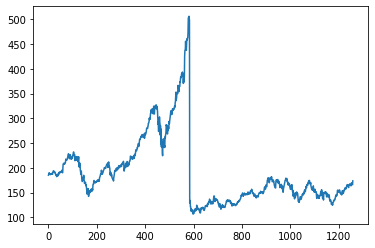

In [9]:
plt.plot(df1)

### LSTM are sensitive to the scale of the data, hence MinMax Scaler is applied

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
df1

array([[0.19616781],
       [0.19839699],
       [0.20167815],
       ...,
       [0.15180964],
       [0.14765185],
       [0.16713838]])

### Splitting datasets into train and test split

In [12]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size, test_size

(818, 441)

### convert an array of values into a dataset matrix

In [14]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range (len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t, t+1, t+2, t+3 and Y=t+4

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [16]:
X_train.shape, y_train.shape

((717, 100), (717,))

In [17]:
X_test.shape, y_test.shape

((340, 100), (340,))

In [18]:
### reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create Stacked LSTM Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

In [20]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 253ms/step - loss: 0.0432 - val_loss: 6.6452e-04
Epoch 2/100
12/12 [==============================] - 3s 218ms/step - loss: 0.0169 - val_loss: 0.0044
Epoch 3/100
12/12 [==============================] - 2s 159ms/step - loss: 0.0110 - val_loss: 4.1424e-04
Epoch 4/100
12/12 [==============================] - 2s 150ms/step - loss: 0.0091 - val_loss: 4.0146e-04
Epoch 5/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0083 - val_loss: 3.6946e-04
Epoch 6/100
12/12 [==============================] - 2s 180ms/step - loss: 0.0076 - val_loss: 5.7180e-04
Epoch 7/100
12/12 [==============================] - 2s 153ms/step - loss: 0.0068 - val_loss: 7.3070e-04
Epoch 8/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0063 - val_loss: 4.9278e-04
Epoch 9/100
12/12 [==============================] - 2s 153ms/step - loss: 0.0053 - val_loss: 3.3141e-04
Epoch 10/100
12/12 [==============================] - 2s 14

12/12 [==============================] - 2s 144ms/step - loss: 0.0016 - val_loss: 2.7118e-04
Epoch 79/100
12/12 [==============================] - 2s 142ms/step - loss: 0.0014 - val_loss: 2.9811e-04
Epoch 80/100
12/12 [==============================] - 2s 146ms/step - loss: 0.0013 - val_loss: 2.6717e-04
Epoch 81/100
12/12 [==============================] - 2s 143ms/step - loss: 0.0016 - val_loss: 4.7996e-04
Epoch 82/100
12/12 [==============================] - 2s 143ms/step - loss: 0.0023 - val_loss: 2.8965e-04
Epoch 83/100
12/12 [==============================] - 2s 143ms/step - loss: 0.0032 - val_loss: 2.9154e-04
Epoch 84/100
12/12 [==============================] - 2s 142ms/step - loss: 0.0028 - val_loss: 5.1566e-04
Epoch 85/100
12/12 [==============================] - 2s 143ms/step - loss: 0.0021 - val_loss: 2.8407e-04
Epoch 86/100
12/12 [==============================] - 2s 145ms/step - loss: 0.0019 - val_loss: 2.6860e-04
Epoch 87/100
12/12 [==============================] - 2s 14

In [41]:
model.save('stackedLSTM_model.h5')

In [24]:
### Let's Do prediction and check performance metrics

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 29ms/step


In [25]:
## Transformback to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [26]:
## Calculate RMSE performance metrics

math.sqrt(mean_squared_error(y_train, train_predict))

228.73216470910492

In [27]:
### Test data RMSE

math.sqrt(mean_squared_error(y_test, test_predict))

152.90727112243044

### Plotting

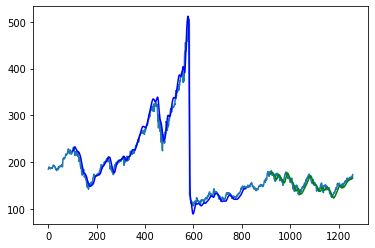

In [28]:
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot, 'b')
plt.plot(testPredictPlot, 'g')
plt.show()

In [29]:
len(test_data)

441

In [30]:
x_input = test_data[341:].reshape(1, -1)
x_input.shape

(1, 100)

In [31]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [32]:
temp_input

[0.0943018159048215,
 0.096756418284283,
 0.09109580463368816,
 0.07428929242329363,
 0.06930494677520344,
 0.06394489668127734,
 0.06376956793988725,
 0.07165936130244199,
 0.0635942391984971,
 0.06266750156543521,
 0.05808390732623664,
 0.04809016906700059,
 0.05703193487789604,
 0.05783343769567939,
 0.04566061365059482,
 0.04889167188478394,
 0.045535378835316165,
 0.05705698184095176,
 0.05838447088290544,
 0.05983719474013771,
 0.06675015654351907,
 0.0665497808390732,
 0.0699311208515967,
 0.0728866624921728,
 0.07105823418910456,
 0.07120851596743893,
 0.07772072636192856,
 0.08583594239198494,
 0.08939261114589853,
 0.08771446462116467,
 0.09297432686286783,
 0.09790857858484658,
 0.09056981840951783,
 0.0938008766437069,
 0.09665623043206006,
 0.11015654351909826,
 0.11937382592360674,
 0.1124358171571696,
 0.11974953036944269,
 0.11291170945522849,
 0.11028177833437691,
 0.1106324358171571,
 0.11774577332498432,
 0.11611772072636184,
 0.12145272385723233,
 0.1173951158422041

In [33]:
# demonstrate prediction for next 10 days

lst_output=[]
n_steps = 100
i = 0
while(i < 30):
    if(len(temp_input) > 100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose = 0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i+1
        
print(lst_output)

[0.14901295]
101
1 day input [0.09675642 0.0910958  0.07428929 0.06930495 0.0639449  0.06376957
 0.07165936 0.06359424 0.0626675  0.05808391 0.04809017 0.05703193
 0.05783344 0.04566061 0.04889167 0.04553538 0.05705698 0.05838447
 0.05983719 0.06675016 0.06654978 0.06993112 0.07288666 0.07105823
 0.07120852 0.07772073 0.08583594 0.08939261 0.08771446 0.09297433
 0.09790858 0.09056982 0.09380088 0.09665623 0.11015654 0.11937383
 0.11243582 0.11974953 0.11291171 0.11028178 0.11063244 0.11774577
 0.11611772 0.12145272 0.11739512 0.11448967 0.10429555 0.10537257
 0.10659987 0.09986224 0.10289292 0.10161553 0.09635567 0.09785848
 0.11068253 0.11769568 0.11211021 0.11529117 0.10958046 0.10434565
 0.1092799  0.11458986 0.11559173 0.12275517 0.12062617 0.12663745
 0.13134627 0.12771446 0.13046963 0.13377583 0.12884158 0.12726362
 0.13507827 0.13906074 0.14542267 0.14860363 0.1472511  0.14256731
 0.14482154 0.13823419 0.13515341 0.13340013 0.14707577 0.14619912
 0.14624922 0.14935504 0.15226049

8 day output [[0.14988618]]
9 day input [0.0626675  0.05808391 0.04809017 0.05703193 0.05783344 0.04566061
 0.04889167 0.04553538 0.05705698 0.05838447 0.05983719 0.06675016
 0.06654978 0.06993112 0.07288666 0.07105823 0.07120852 0.07772073
 0.08583594 0.08939261 0.08771446 0.09297433 0.09790858 0.09056982
 0.09380088 0.09665623 0.11015654 0.11937383 0.11243582 0.11974953
 0.11291171 0.11028178 0.11063244 0.11774577 0.11611772 0.12145272
 0.11739512 0.11448967 0.10429555 0.10537257 0.10659987 0.09986224
 0.10289292 0.10161553 0.09635567 0.09785848 0.11068253 0.11769568
 0.11211021 0.11529117 0.10958046 0.10434565 0.1092799  0.11458986
 0.11559173 0.12275517 0.12062617 0.12663745 0.13134627 0.12771446
 0.13046963 0.13377583 0.12884158 0.12726362 0.13507827 0.13906074
 0.14542267 0.14860363 0.1472511  0.14256731 0.14482154 0.13823419
 0.13515341 0.13340013 0.14707577 0.14619912 0.14624922 0.14935504
 0.15226049 0.14980589 0.14572323 0.14649969 0.14259236 0.14256731
 0.15421415 0.15739512

17 day output [[0.14523625]]
18 day input [0.05838447 0.05983719 0.06675016 0.06654978 0.06993112 0.07288666
 0.07105823 0.07120852 0.07772073 0.08583594 0.08939261 0.08771446
 0.09297433 0.09790858 0.09056982 0.09380088 0.09665623 0.11015654
 0.11937383 0.11243582 0.11974953 0.11291171 0.11028178 0.11063244
 0.11774577 0.11611772 0.12145272 0.11739512 0.11448967 0.10429555
 0.10537257 0.10659987 0.09986224 0.10289292 0.10161553 0.09635567
 0.09785848 0.11068253 0.11769568 0.11211021 0.11529117 0.10958046
 0.10434565 0.1092799  0.11458986 0.11559173 0.12275517 0.12062617
 0.12663745 0.13134627 0.12771446 0.13046963 0.13377583 0.12884158
 0.12726362 0.13507827 0.13906074 0.14542267 0.14860363 0.1472511
 0.14256731 0.14482154 0.13823419 0.13515341 0.13340013 0.14707577
 0.14619912 0.14624922 0.14935504 0.15226049 0.14980589 0.14572323
 0.14649969 0.14259236 0.14256731 0.15421415 0.15739512 0.15716969
 0.15453976 0.15180964 0.14765185 0.16713838 0.14901295 0.14998278
 0.15064275 0.1509859

25 day output [[0.1408283]]
26 day input [0.07772073 0.08583594 0.08939261 0.08771446 0.09297433 0.09790858
 0.09056982 0.09380088 0.09665623 0.11015654 0.11937383 0.11243582
 0.11974953 0.11291171 0.11028178 0.11063244 0.11774577 0.11611772
 0.12145272 0.11739512 0.11448967 0.10429555 0.10537257 0.10659987
 0.09986224 0.10289292 0.10161553 0.09635567 0.09785848 0.11068253
 0.11769568 0.11211021 0.11529117 0.10958046 0.10434565 0.1092799
 0.11458986 0.11559173 0.12275517 0.12062617 0.12663745 0.13134627
 0.12771446 0.13046963 0.13377583 0.12884158 0.12726362 0.13507827
 0.13906074 0.14542267 0.14860363 0.1472511  0.14256731 0.14482154
 0.13823419 0.13515341 0.13340013 0.14707577 0.14619912 0.14624922
 0.14935504 0.15226049 0.14980589 0.14572323 0.14649969 0.14259236
 0.14256731 0.15421415 0.15739512 0.15716969 0.15453976 0.15180964
 0.14765185 0.16713838 0.14901295 0.14998278 0.15064275 0.15098597
 0.15106337 0.15093976 0.15067385 0.15031162 0.14988618 0.1494201
 0.14892809 0.14841962 

In [34]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [35]:
len(df1)

1259

In [36]:
df3 = df1.tolist()
df3.extend(lst_output)

In [37]:
day_new.shape, df1[1159:].shape

((100,), (100, 1))

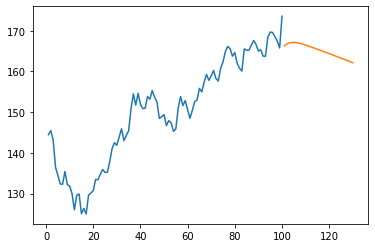

In [38]:
plt.plot(day_new, scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

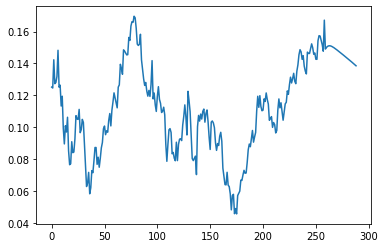

In [39]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])

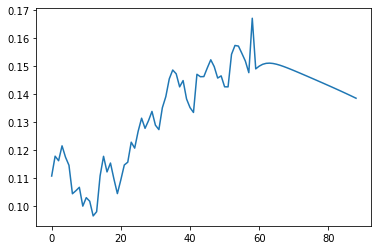

In [40]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])